In [ ]:
!pip install osmnx matplotlib geopandas shapely scipy networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python-headless matplotlib scikit-learn scipy

In [ ]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import nearest_points
from datetime import datetime, timezone
import json
import platform

In [15]:
place_name = "Carouge, Switzerland"
output_image = "/content/input.png"
metadata_file = "/content/osm_metadata.json"

# Entry/exit node coordinates (lat, lon) [Can be any point that must be part of the network system]
node_coords = [
    (46.188551, 6.137280), (46.187556, 6.128139),
    (46.181008, 6.131449), (46.176755, 6.133330),
    (46.172416, 6.138938),
    (46.177494, 6.145831), (46.183708, 6.152934),
    (46.186308, 6.146615), (46.187901, 6.141408)
]


extraction_time_utc = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S UTC")

print(f"OSM data extraction time: {extraction_time_utc}")
print(f"OSMnx version: {ox.__version__}")

OSM data extraction time: 2026-01-08 18:44:11 UTC
OSMnx version: 2.0.7


In [16]:

city_boundary = ox.geocode_to_gdf(place_name)
boundary_geom = city_boundary.geometry.iloc[0]

tags = {
    "building": True,
    "landuse": ["forest", "grass", "meadow", "park"],
    "natural": ["wood", "grassland", "water"]
}

features = ox.features_from_place(place_name, tags=tags)
features = gpd.overlay(features, city_boundary, how="intersection")

buildings = features[features["building"].notna()]

nodes_gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lat, lon in node_coords],
    crs="EPSG:4326"
)

def move_to_boundary(point, boundary):
    if boundary.contains(point):
        return point
    return nearest_points(boundary, point)[0]

nodes_gdf["geometry"] = nodes_gdf["geometry"].apply(
    lambda p: move_to_boundary(p, boundary_geom)
)


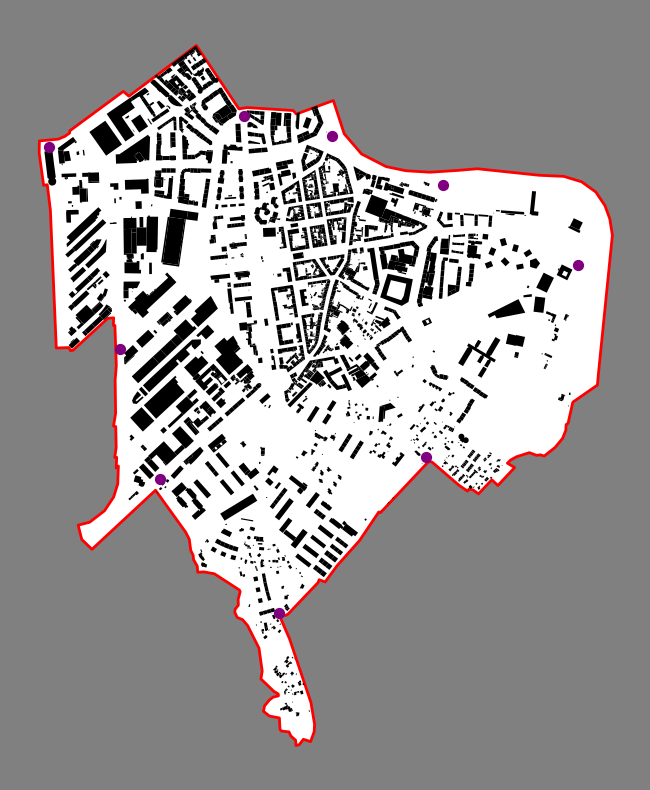

In [17]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor="gray")

city_boundary.plot(
    ax=ax,
    edgecolor="red",
    facecolor="white",
    linewidth=2,
    label="Boundary"
)

buildings.plot(
    ax=ax,
    color="black",
    edgecolor="black",
    linewidth=0
)

nodes_gdf.plot(
    ax=ax,
    color="purple",
    markersize=50,
    label="Entry/Exit Nodes"
)

ax.set_facecolor("gray")
ax.axis("off")

plt.savefig(
    output_image,
    dpi=300,
    bbox_inches="tight",
    facecolor="gray"
)

plt.show()

In [18]:
metadata = {
    "place_name": place_name,
    "extraction_time_utc": extraction_time_utc,
    "osmnx_version": ox.__version__,
    "python_version": platform.python_version(),
    "coordinate_reference_system": "EPSG:4326",
    "osm_tags_used": tags,
    "number_of_buildings": int(len(buildings)),
    "number_of_entry_exit_nodes": len(nodes_gdf),
    "image_resolution_dpi": 300
}

with open(metadata_file, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Saved OSM metadata to: {metadata_file}")

print("\n=== OSM EXTRACTION METADATA ===")
for k, v in metadata.items():
    print(f"{k}: {v}")

Saved OSM metadata to: /content/osm_metadata.json

=== OSM EXTRACTION METADATA ===
place_name: Carouge, Switzerland
extraction_time_utc: 2026-01-08 18:44:11 UTC
osmnx_version: 2.0.7
python_version: 3.12.12
coordinate_reference_system: EPSG:4326
osm_tags_used: {'building': True, 'landuse': ['forest', 'grass', 'meadow', 'park'], 'natural': ['wood', 'grassland', 'water']}
number_of_buildings: 2309
number_of_entry_exit_nodes: 9
image_resolution_dpi: 300
